## Import common libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
%matplotlib inline

In [12]:
yelp = pd.read_csv('yelp_training_set_review(with text_length and transformed).csv')

In [13]:
yelp['text_transformed'] = yelp['text_transformed'].astype('str')
yelp[['stars','text_transformed','funny', 'text_length']].head()

,stars,text_transformed,funny,text_length
0,5,wife took birthday breakfast excellent weather...,0,78
1,5,idea people give bad reviews place goes show p...,0,120
2,4,love gyro plate Rice good also dig candy selec...,0,9
3,5,Rosie Dakota LOVE Chaparral Dog Park convenien...,0,44
4,5,General Manager Scott Petello good egg go deta...,0,38


## Predictions
#### Lets focus for now on star 1 and 5 only.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,LinearSVC

### Bag of n-grams Vectorization, Train Test Split and Training a Support Vector Machine classifier

In [8]:
def ML_LSVC(X_vector, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.3, random_state=101)
    svm = LinearSVC()
    svm.fit(X_train,y_train)
    y_pred_svm = svm.predict(X_test)
    compare_models[model_name] = {'mean':svm.score(X_test,y_test)}
    for i in ['1','5']:
        compare_models[model_name][i]=classification_report(y_test,y_pred_svm,output_dict=True)[i]['f1-score']

## 1. Features engineering
## 2. Data imbalance
## 3. Skewed distribution
## 4. Effect of n-grams
## 5. Effect of tf-idf
## 6. Tuning hyperparameters
## 7. Cross-validation

In [9]:
compare_models = {}

## 1. Features engineering: compare text-only vs text+funny+text_length

In [15]:
yelp_class = yelp[(yelp.stars==1) | (yelp.stars==5)].copy()
yelp_class.dropna(inplace=True)
yelp_class = yelp_class.sample(frac=0.5, random_state=101)
X = yelp_class['text_transformed']
y = yelp_class['stars']
len(yelp_class)

46854

In [23]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

In [25]:
class LemmaNonumberTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t.isalpha()]

In [29]:
hs = HashingVectorizer(tokenizer=LemmaNonumberTokenizer())
X_vector = hs.fit_transform(X)

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [30]:
X_all_featues = pd.DataFrame.sparse.from_spmatrix(X_vector,columns=cv.get_feature_names())
X_all_featues.head()

ValueError: Column length mismatch: 49336 vs. 1048576

In [13]:
X_all_featues[['text_length', 'funny']] = yelp_class[['text_length', 'funny']].reset_index().drop(['index'],axis=1)
X_all_featues.head()

,00,000,000s,000th,001,00453636268,005,007,0073545449,00a,...,álvares,ça,çarradinhas,çe,éclairs,élysées,ém,über,überraschungseier,text_length
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,54
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50


In [41]:
compare_models = {}
for i,j in zip([X_all_featues.drop(['text_length', 'funny'], axis=1),
                X_all_featues.drop(['funny'], axis=1),
                X_all_featues], ['Text','Text+text_length','Text+text_length+funny']):
    ML_LSVC(i,y,j)
pd.DataFrame(compare_models).plot(kind='bar', ylim=[0.8,1.0])
plt.legend(loc=(1,0))
plt.ylabel('score')
pd.DataFrame(compare_models)

TypeError: ML_LSVC() missing 2 required positional arguments: 'y_test' and 'model_name'

## 2. data imbalance
- ### Oversampling and Undersampling

Text(0.5, 1.0, 'ratings counts')

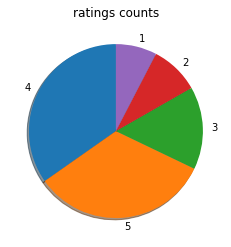

In [14]:
plt.pie(yelp['stars'].value_counts(), 
        labels=yelp['stars'].value_counts().index,
        shadow=True, startangle=90)
plt.title('ratings counts')

In [6]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN,  BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

In [36]:
def ML_LSVC(X_train, X_test, y_train, y_test, model_name):
    svm = LinearSVC()
    svm.fit(X_train,y_train)
    y_pred_svm = svm.predict(X_test)
    compare_models[model_name] = {'mean':svm.score(X_test,y_test)}
    for i in ['1','5']:
        compare_models[model_name][i]=classification_report(y_test,y_pred_svm,output_dict=True)[i]['f1-score']

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,LSVC,LSVC + RandomOverSampler,LSVC + SMOTE,LSVC + ADASYN,LSVC + BorderlineSMOTE,LSVC + RandomUnderSampler
mean,0.949918,0.910953,0.949952,0.949586,0.952922,0.920437
1,0.863619,0.905650,0.949904,0.950378,0.952942,0.919776
5,0.969327,0.915692,0.950000,0.948768,0.952901,0.921088


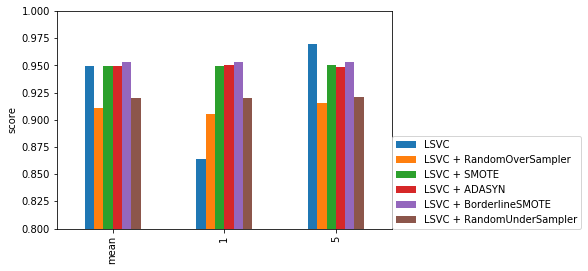

In [18]:
compare_models = {}
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.3, random_state=101)
ML_LSVC(X_train, X_test, y_train, y_test,'LSVC')
for method in [RandomOverSampler, SMOTE, ADASYN,  BorderlineSMOTE, RandomUnderSampler]:
    ros = method(random_state=5)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_resampled_test, y_resampled_test = ros.fit_resample(X_test, y_test)
    #display(pd.DataFrame({'before:': y_train.value_counts(), 'balanced to':y_resampled.value_counts()}))
    ML_LSVC(X_resampled, X_resampled_test, y_resampled, y_resampled_test,'LSVC + ' + ros.__class__.__name__)
pd.DataFrame(compare_models).plot(kind='bar', ylim=[0.8,1.0])
plt.legend(loc=(1,0))
plt.ylabel('score')
pd.DataFrame(compare_models)

## 3. skewed distribution

In [7]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

,LSVC,LSVC + BorderlineSMOTE,LSVC + BorderlineSMOTE + Yeo-Johnson
mean,0.949918,0.953009,0.954013
1,0.863619,0.953030,0.954128
5,0.969327,0.952988,0.953899


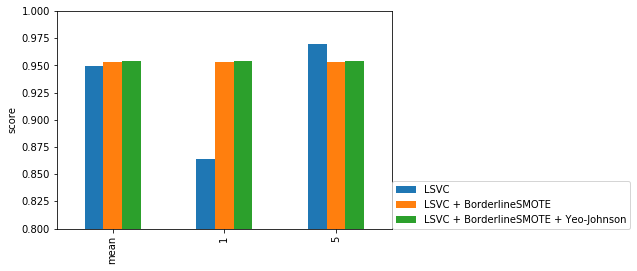

In [40]:
compare_models = {}

ros = BorderlineSMOTE(random_state=5)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_resampled_test, y_resampled_test = ros.fit_resample(X_test, y_test)


pt = QuantileTransformer() 
pt.fit(X_resampled)
X_train_TF = pt.transform(X_resampled)
X_test_TF = pt.transform(X_resampled_test)

ML_LSVC(X_train, X_test, y_train, y_test, 'LSVC')
ML_LSVC(X_resampled, X_resampled_test, y_resampled, y_resampled_test, 'LSVC + BorderlineSMOTE')
ML_LSVC(X_train_TF, X_test_TF, y_resampled, y_resampled_test, 'LSVC + BorderlineSMOTE + Yeo-Johnson')

pd.DataFrame(compare_models).plot(kind='bar', ylim=[0.8,1.0])
plt.legend(loc=(1,0))
plt.ylabel('score')
pd.DataFrame(compare_models)

## 4. effect of n-grams

,"LSVC +(1, 1)","LSVC +(1, 2)","LSVC +(2, 2)"
mean,0.949918,0.954400,0.909725
1,0.863619,0.874486,0.706590
5,0.969327,0.972139,0.946656


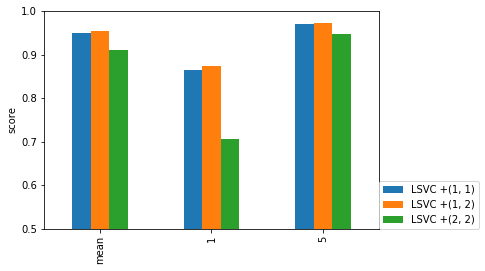

In [48]:
compare_models = {}
for i in [(1,1) ,(1,2), (2,2)]:
    cv = CountVectorizer(ngram_range=i)
    X_vector = cv.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.3, random_state=101)
    ML_LSVC(X_train, X_test, y_train, y_test, f'LSVC +{i}')
pd.DataFrame(compare_models).plot(kind='bar', ylim=[0.5,1.0])
plt.legend(loc=(1,0))
plt.ylabel('score')
pd.DataFrame(compare_models)

## 5. effect of Tf-idf

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,"LSVC + (1,2)",LSVC + tdidf
mean,0.954400,0.959522
1,0.874486,0.882121
5,0.972139,0.975566


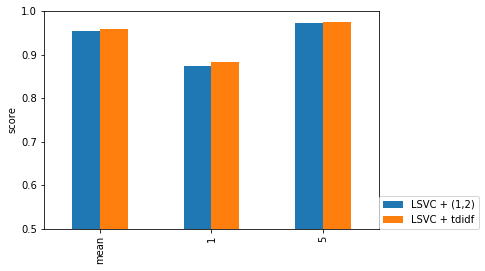

In [52]:
compare_models = {}
cv = CountVectorizer(ngram_range=(1,2))
X_vector = cv.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.3, random_state=101)
ML_LSVC(X_train, X_test, y_train, y_test, 'LSVC + (1,2)')


tfidf = TfidfTransformer()
X_vector_tdidf = tfidf.fit_transform(X_vector,y)
X_train, X_test, y_train, y_test = train_test_split(X_vector_tdidf, y, test_size=0.3, random_state=101)
ML_LSVC(X_train, X_test, y_train, y_test, f'LSVC + tdidf')
pd.DataFrame(compare_models).plot(kind='bar', ylim=[0.5,1.0])
plt.legend(loc=(1,0))
plt.ylabel('score')
pd.DataFrame(compare_models)

## 6. Tuning hyperparameters

In [9]:
from pprint import pprint
from time import time
import logging

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [10]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('oversample', BorderlineSMOTE()),
    ('unskewed', QuantileTransformer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC())
])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__norm': ('l1', 'l2'),    
    'svm__C': [10,20,50,70]
}

In [12]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'oversample', 'unskewed', 'tfidf', 'svm']
parameters:
{'tfidf__use_idf': (True, False)}
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 46.1min finished


done in 3825.070s

Best score: 0.955
Best parameters set:
	tfidf__use_idf: True


In [23]:
#from tpot import TPOTClassifier

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.3, random_state=101)
#pipeline_optimizer = TPOTClassifier(generations=20, verbosity=2, config_dict='TPOT sparse', n_jobs=-1)
#pipeline_optimizer.fit(X_train, y_train)
#print(pipeline_optimizer.score(X_test, y_test))
#pipeline_optimizer.export('tpot_exported_pipeline.py')